In [1]:
import cartopy

In [2]:
import xarray as xr
import sys
sys.path.insert(0,"/home/albert/lib/python")

import numpy as np
sys.path.insert(0,"/home/albert/Work/git/xscale")
import xscale
import xscale.spectral.fft as xfft
from matplotlib.colors import LogNorm
import cmocean
import matplotlib.pylab as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

sys.path.insert(0,"/home/albert/lib/python/w_k_scripts")
import Wavenum_freq_spec_func as wfs

/home/albert/anaconda2/lib/python2.7/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [3]:
gridfile="/mnt/albert/equipes/IGE/meom/MODEL_SET/eNATL60/eNATL60-I/mesh_mask_eNATL60_3.6.nc"
dsgrid=xr.open_mfdataset(gridfile)
ff=dsgrid['ff']

In [4]:
def plot_surf(sub,data,lon,lat,vmin,vmax,cmap,title):
    
    ax = plt.subplot(sub,projection=ccrs.PlateCarree(central_longitude=0))
    ax.set_extent((-36, -26, 25, 40))
    land = cfeature.GSHHSFeature(scale='intermediate',
                                 levels=[1],
                                 facecolor=cfeature.COLORS['land'])
    ax.add_feature(land)
    gl = ax.gridlines(draw_labels=True, linestyle=':', color='black',
                      alpha=0.5)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.tick_params('both',labelsize=22)

    plt.pcolormesh(lon,lat,data,cmap=cmap,vmin=vmin,vmax=vmax )
    plt.colorbar(orientation='horizontal',pad=0.1)
    plt.title(title)

    ax.plot([-31, -28], [33, 33],color='black',linewidth=4)
    ax.plot([-31, -28], [36, 36],color='black',linewidth=4)
    ax.plot([-31, -31], [33, 36],color='black',linewidth=4)
    ax.plot([-28, -28], [33, 36],color='black',linewidth=4)


In [13]:
print np.min(ff[0].values),np.max(ff[0].values)

1.6118568566538608e-05 0.00013463505001099854


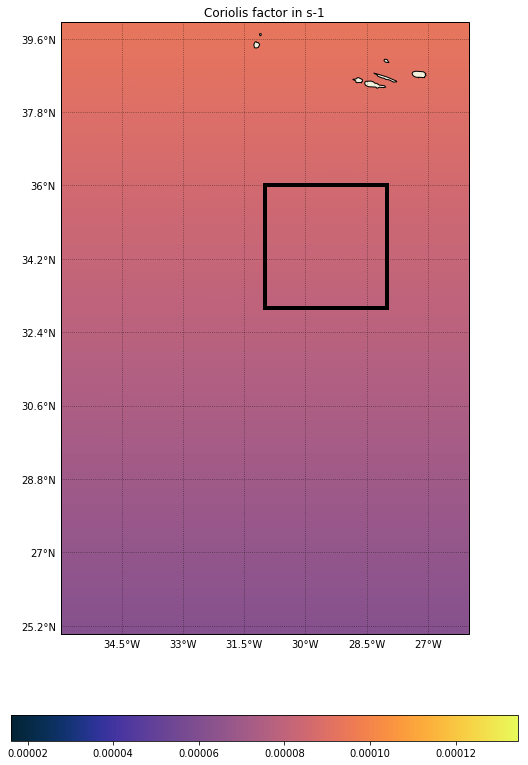

In [15]:
fig=plt.figure(figsize=(20,15))

navlat= dsgrid['nav_lat']
navlon= dsgrid['nav_lon']
plot_surf(121,ff[0],navlon,navlat,np.min(ff[0].values),np.max(ff[0].values),cmocean.cm.thermal,'Coriolis factor in s-1')



In [16]:
## Dataset

dirtide="/mnt/albert/equipes/IGE/meom/MODEL_SET/eNATL60/eNATL60-BLBT02-S/1h/ACO/"
dirnotide="/mnt/albert/equipes/IGE/meom/MODEL_SET/eNATL60/eNATL60-BLB002-S/1h/ACO/"



In [17]:
filesUtide="eNATL60ACO-BLBT02_1h_*_gridU-2D_*.nc"
filesVtide="eNATL60ACO-BLBT02_1h_*_gridV-2D_*.nc"

tfilesUtide=dirtide+filesUtide
tfilesVtide=dirtide+filesVtide

filesUnotide="eNATL60ACO-BLB002_1h_*_gridU-2D_*.nc"
filesVnotide="eNATL60ACO-BLB002_1h_*_gridV-2D_*.nc"

tfilesUnotide=dirnotide+filesUnotide
tfilesVnotide=dirnotide+filesVnotide


In [18]:
fUtide = xr.open_mfdataset(tfilesUtide)
Utide=fUtide['sozocrtx'][:]
navlat= fUtide['nav_lat']
navlon= fUtide['nav_lon']

fUnotide = xr.open_mfdataset(tfilesUnotide)
Unotide=fUnotide['sozocrtx'][:]

fVtide = xr.open_mfdataset(tfilesVtide)
Vtide=fVtide['somecrty'][:]

fVnotide = xr.open_mfdataset(tfilesVnotide)
Vnotide=fVnotide['somecrty'][:]


In [19]:
wutide=Utide.window
wutide.set(n=30,dim='time_counter', cutoff=10000)
Utidefilt=wutide.convolve()

In [20]:
wvtide=Vtide.window
wvtide.set(n=30,dim='time_counter', cutoff=10000)
Vtidefilt=wvtide.convolve()

In [21]:
box=(-31,-28,33,36)
domain=(box[0]<navlon)*(navlon<box[1])*(box[2]<navlat)*(navlat<box[3])
where=np.where(domain)

lats=navlat[where]
lons=navlon[where]


In [22]:

ind = np.unravel_index(np.argmin(lats, axis=None), lats.shape)
jmin = where[0][ind[0]]
ind = np.unravel_index(np.argmax(lats, axis=None), lats.shape)
jmax = where[0][ind[0]]
ind = np.unravel_index(np.argmin(lons, axis=None), lons.shape)
imin = where[1][ind[1]]
ind = np.unravel_index(np.argmax(lons, axis=None), lons.shape)
imax = where[1][ind[1]]


In [23]:
Utidefiltbox=Utidefilt[:,jmin:jmax+1,imin:imax+1]
Vtidefiltbox=Vtidefilt[:,jmin:jmax+1,imin:imax+1]

dx,dy = wfs.get_dx_dy(Utidefiltbox[0])
Utide_No_NaN = Utidefiltbox.interpolate_na(dim='y')
Utide_dtr = wfs.detrendn(Utide_No_NaN,axes=[0,1,2])
Utide_wdw = wfs.apply_window(Utide_dtr, Utide_dtr.dims, window_type='hanning')
Utidehat = xfft.fft(Utide_wdw, dim=('time_counter', 'x', 'y'), dx={'x': dx, 'y': dx}, sym=True)
Utide_psd = xfft.psd(Utidehat)
Utide_frequency,kx,ky = wfs.get_f_kx_ky(Utidehat)
Utidefilt_wavenumber,kradial = wfs.get_wavnum_kradial(kx,ky)
Utidefilt_psd_np = Utide_psd.values
Utidefilt_wavenum_freq_spectrum = wfs.get_f_k_in_2D(kradial,Utidefilt_wavenumber,Utidefilt_psd_np)

dx,dy = wfs.get_dx_dy(Vtidefiltbox[0])
Vtide_No_NaN = Vtidefiltbox.interpolate_na(dim='y')
Vtide_dtr = wfs.detrendn(Vtide_No_NaN,axes=[0,1,2])
Vtide_wdw = wfs.apply_window(Vtide_dtr, Vtide_dtr.dims, window_type='hanning')
Vtidehat = xfft.fft(Vtide_wdw, dim=('time_counter', 'x', 'y'), dx={'x': dx, 'y': dx}, sym=True)
Vtide_psd = xfft.psd(Vtidehat)
Vtide_frequency,kx,ky = wfs.get_f_kx_ky(Vtidehat)
Vtidefilt_wavenumber,kradial = wfs.get_wavnum_kradial(kx,ky)
Vtidefilt_psd_np = Vtide_psd.values
Vtidefilt_wavenum_freq_spectrum = wfs.get_f_k_in_2D(kradial,Vtidefilt_wavenumber,Vtidefilt_psd_np)

KEtidefilt_wavenum_freq_spectrum=0.5*(Utidefilt_wavenum_freq_spectrum+Vtidefilt_wavenum_freq_spectrum)


0
100
200
300
400
500
600
700
0
100
200
300
400
500
600
700


In [24]:
Utidebox=Utide[:,jmin:jmax+1,imin:imax+1]
Vtidebox=Vtide[:,jmin:jmax+1,imin:imax+1]

dx,dy = wfs.get_dx_dy(Utidebox[0])
Utide_No_NaN = Utidebox.interpolate_na(dim='y')
Utide_dtr = wfs.detrendn(Utide_No_NaN,axes=[0,1,2])
Utide_wdw = wfs.apply_window(Utide_dtr, Utide_dtr.dims, window_type='hanning')
Utidehat = xfft.fft(Utide_wdw, dim=('time_counter', 'x', 'y'), dx={'x': dx, 'y': dx}, sym=True)
Utide_psd = xfft.psd(Utidehat)
Utide_frequency,kx,ky = wfs.get_f_kx_ky(Utidehat)
Utide_wavenumber,kradial = wfs.get_wavnum_kradial(kx,ky)
Utide_psd_np = Utide_psd.values
Utide_wavenum_freq_spectrum = wfs.get_f_k_in_2D(kradial,Utide_wavenumber,Utide_psd_np)

dx,dy = wfs.get_dx_dy(Vtidebox[0])
Vtide_No_NaN = Vtidebox.interpolate_na(dim='y')
Vtide_dtr = wfs.detrendn(Vtide_No_NaN,axes=[0,1,2])
Vtide_wdw = wfs.apply_window(Vtide_dtr, Vtide_dtr.dims, window_type='hanning')
Vtidehat = xfft.fft(Vtide_wdw, dim=('time_counter', 'x', 'y'), dx={'x': dx, 'y': dx}, sym=True)
Vtide_psd = xfft.psd(Vtidehat)
Vtide_frequency,kx,ky = wfs.get_f_kx_ky(Vtidehat)
Vtide_wavenumber,kradial = wfs.get_wavnum_kradial(kx,ky)
Vtide_psd_np = Vtide_psd.values
Vtide_wavenum_freq_spectrum = wfs.get_f_k_in_2D(kradial,Vtide_wavenumber,Vtide_psd_np)

KEtide_wavenum_freq_spectrum=0.5*(Utide_wavenum_freq_spectrum+Vtide_wavenum_freq_spectrum)


0
100
200
300
400
500
600
700
0
100
200
300
400
500
600
700


In [58]:
T=2*np.pi/(3600.0*1E-4)
print T

17.4532925199


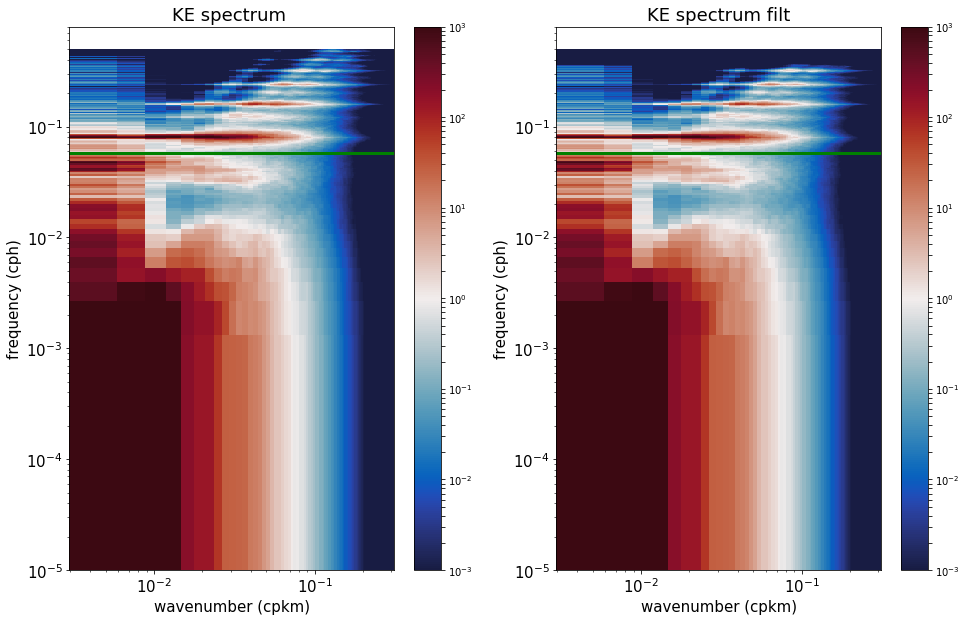

In [59]:
sec_to_hour = 3600.0
norm = LogNorm(vmin=0.001,vmax=1000)
cmap = cmocean.cm.balance

fig=plt.figure(figsize=(16,10))

ax = plt.subplot(121)
plt.pcolormesh(Utide_wavenumber,sec_to_hour*Utide_frequency,KEtide_wavenum_freq_spectrum,norm=norm,cmap=cmap)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel('wavenumber (cpkm)',fontsize=15)
ax.set_ylabel('frequency (cph)',fontsize=15)
ax.set_xlim(Utide_wavenumber.min(),Utide_wavenumber.max())
ax.set_ylim(1E-5,8E-1)
plt.axhline(y=1/T,color='g', label="mean Coriolis freq",linewidth=3)
ax.set_title('KE spectrum ',size=18)
ax.tick_params(labelsize=15)
plt.legend
plt.colorbar()

ax = plt.subplot(122)
plt.pcolormesh(Utidefilt_wavenumber,sec_to_hour*Utide_frequency,KEtidefilt_wavenum_freq_spectrum,norm=norm,cmap=cmap)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel('wavenumber (cpkm)',fontsize=15)
ax.set_ylabel('frequency (cph)',fontsize=15)
ax.set_xlim(Utidefilt_wavenumber.min(),Utidefilt_wavenumber.max())
ax.set_ylim(1E-5,8E-1)
ax.axhline(y=1/T,color='g', label="mean Coriolis freq",linewidth=3)
ax.set_title('KE spectrum filt',size=18)
ax.tick_params(labelsize=15)
plt.legend
plt.colorbar()